In [ ]:
from ais_dataloader import *
from gp_kernel_ship_classification_dataset import *
from gp_kernel_ship_classification_trainer import *
from gp_kernel_ship_classification_network import *

import time
import gc
import torch
import gpytorch
from torch.profiler import profile, record_function, ProfilerActivity
import ipywidgets as widgets
from IPython.display import display
from plotting_utils import *
from state_space_kernel import *

from multioutput_state_space_gp import *
from state_space_kernel import *
from plotting_utils import *


%load_ext autoreload
%autoreload 2


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Load Data

In [2]:
date_range = pd.date_range(start='2024-01-01', end='2024-01-01', freq='D')
gp_regression_dataset = AISTrajectoryRegressionDataset(date_range, device)


Loading cached dataframe from data/processed/processed_AIS_df_2024_01_01_2024_01_01.pkl


Scaling trajectories for each MMSI: 100%|██████████| 3453/3453 [00:01<00:00, 2907.28it/s]


===== Dataset Statistics =====
Total number of AIS messages: 2128288
Number of unique MMSIs: 3453
Date range: 2024-01-01 00:00:00 to 2024-01-01 23:59:59


## Fit GP Models

In [3]:
# num_trajectories = len(gp_regression_dataset)
num_trajectories = 1
models = {}
likelihoods = {}
losses = {}

for idx in range(num_trajectories):
    # mmsi, times, state_trajectory = gp_regression_dataset[idx]
    mmsi, times, state_trajectory = gp_regression_dataset[idx]
    
    times = times[:10]
    state_trajectory = state_trajectory[:10, :]
    
    print(f"\nFitting GP for trajectory {idx+1}/{num_trajectories} for MMSI {mmsi}")
    
    print(f"Times shape: {times.shape}, State trajectory shape: {state_trajectory.shape}")
    times_tensor = times.detach().to(device)


    X_indices = torch.arange(len(times), device=device).unsqueeze(1)
    
    Y = state_trajectory.detach().to(device) # Targets are shape [time_steps, n_states]
    num_tasks = Y.shape[1]
    # Y_flat = Y.reshape(-1)  # Reshape to [time_steps * state_dims]
    
    # Use regular Gaussian likelihood
    # likelihood = gpytorch.likelihoods.GaussianLikelihood(
    #     # noise_prior=gpytorch.priors.NormalPrior(loc=0.25, scale=0.25)
    # ).to(device)
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks).to(device)
    
    # likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_outputs).to(device)
    
    # GP model with state space kernel
    model = StateSpaceGPModel(X_indices, Y, likelihood, timesteps=times_tensor, num_tasks=num_tasks).to(device)


    # Train with jitter for numerical stability
    with gpytorch.settings.cholesky_jitter(1e-3):
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        
        # Training loop
        model.train()
        likelihood.train()

        for i in tqdm(range(100), desc=f"Trajectory {idx+1}/{num_trajectories}"):  # num_epochs
            optimizer.zero_grad()
            output = model(X_indices)
            loss = -mll(output, Y.reshape(-1))
            loss.backward()
            optimizer.step()
            
            
            if (i+1) % 10 == 0:
                print(f'MMSI {mmsi} - Epoch {i+1}/100 - Loss: {loss.item():.4f}')
                

    print(f"Final Loss: {loss.item()}")
    models[mmsi] = model
    likelihoods[mmsi] = likelihood
    losses[mmsi] = loss.item()


# current_date = date_range[0].strftime('%Y-%m-%d')
# save_dict = {
#     "models_state_dict": {k: v.state_dict() for k, v in models.items()},
#     "likelihoods_state_dict": {k: v.state_dict() for k, v in likelihoods.items()},
#     "losses": losses,
# }

# save_path = f"kernel_classification_bundle_{current_date}.pt"
# save_path = f"models/state_space_kernel_bundle_{current_date}.pt"
# torch.save(save_dict, save_path)
# print(f"Saved model bundle to {save_path}")


Fitting GP for trajectory 1/1 for MMSI 3660489
Times shape: torch.Size([10]), State trajectory shape: torch.Size([10, 6])
Force kernel 0:
  Outputscale: 1.0
  Lengthscale: 1.0
Force kernel 1:
  Outputscale: 1.0
  Lengthscale: 1.0
Force kernel 2:
  Outputscale: 1.0
  Lengthscale: 1.0


Trajectory 1/1:  10%|█         | 10/100 [00:03<00:33,  2.72it/s]

MMSI 3660489 - Epoch 10/100 - Loss: 0.9993


Trajectory 1/1:  15%|█▌        | 15/100 [00:05<00:33,  2.57it/s]


KeyboardInterrupt: 

## Approximate GP Fitting

In [5]:
# num_trajectories = len(gp_regression_dataset)
num_trajectories = 1
models = {}
likelihoods = {}
losses = {}

from multioutput_state_space_gp import ApproximateStateSpaceGPModel

for idx in range(num_trajectories):
    # mmsi, times, state_trajectory = gp_regression_dataset[idx]
    mmsi, times, state_trajectory = gp_regression_dataset[idx]
    
    
    print(f"\nFitting GP for trajectory {idx+1}/{num_trajectories} for MMSI {mmsi}")
    
    # Define inducing points and indices
    num_inducing = min(5, int(0.1*len(times)))  # Ensure we have roughly 10 percent of data as inducing points or least 5 inducing points
    inducing_indices = X_indices[torch.randperm(len(X_indices))[:num_inducing]]
    inducing_indices = inducing_indices.float()  # Convert to float

    # Create model
    model = ApproximateStateSpaceGPModel(
        inducing_indices, 
        timesteps=times_tensor, 
        num_tasks=num_tasks
    ).to(device)

    # Use the same likelihood
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks).to(device)

    # Optimizer and loss function
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()},
    ], lr=0.05)

    # Use VariationalELBO instead of ExactMarginalLogLikelihood
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(X_indices))

    # Training loop
    model.train()
    likelihood.train()
    print(f"X_indices shape: {X_indices.shape}")
    print(f"Y shape: {Y.shape}")

    for i in tqdm(range(100), desc=f"Trajectory {idx+1}/{num_trajectories}"):
        optimizer.zero_grad()
        output = model(X_indices)
        loss = -mll(output, Y.reshape(-1))
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print(f'MMSI {mmsi} - Epoch {i+1}/100 - Loss: {loss.item():.4f}')


Fitting GP for trajectory 1/1 for MMSI 3660489
Force kernel 0:
  Outputscale: 1.0
  Lengthscale: 1.0
Force kernel 1:
  Outputscale: 1.0
  Lengthscale: 1.0
Force kernel 2:
  Outputscale: 1.0
  Lengthscale: 1.0
X_indices shape: torch.Size([10, 1])
Y shape: torch.Size([10, 6])


Trajectory 1/1:   0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (75) must match the size of tensor b (3) at non-singleton dimension 1

### Assess a single model kernel

In [115]:
model = next(iter(models.values()))  # Get one of the models for demonstration
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.tolist()}')
    
print()
# print(model.covar_module.data_covar_module.kernels[0].lengthscale.item())

Parameter name: likelihood.raw_task_noises                 value = [0.36019831895828247, -0.17114244401454926, -9.697915077209473, -9.667152404785156, -9.66065788269043, -9.564282417297363]
Parameter name: likelihood.raw_noise                       value = [-9.6321439743042]
Parameter name: mean_module.base_means.0.raw_constant      value = -0.4663548767566681
Parameter name: mean_module.base_means.1.raw_constant      value = -0.6230435967445374
Parameter name: mean_module.base_means.2.raw_constant      value = 0.02191898040473461
Parameter name: mean_module.base_means.3.raw_constant      value = -0.28844013810157776
Parameter name: mean_module.base_means.4.raw_constant      value = 0.002824559807777405
Parameter name: mean_module.base_means.5.raw_constant      value = 0.012576199136674404
Parameter name: base_kernel.raw_m                          value = 11.512925148010254
Parameter name: base_kernel.raw_I                          value = 6.907755374908447
Parameter name: base_kernel.

In [121]:
# Set the model and likelihood to evaluation mode
model.eval()
likelihood.eval()

# Generate test inputs (e.g., evenly spaced time points)
test_times = torch.linspace(times.min(), times.max(), 200).unsqueeze(1).to(device)

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.cholesky_jitter(1e-3):
    predictions = likelihood(model(test_times))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()



KeyboardInterrupt: 

### Plot GP Solution

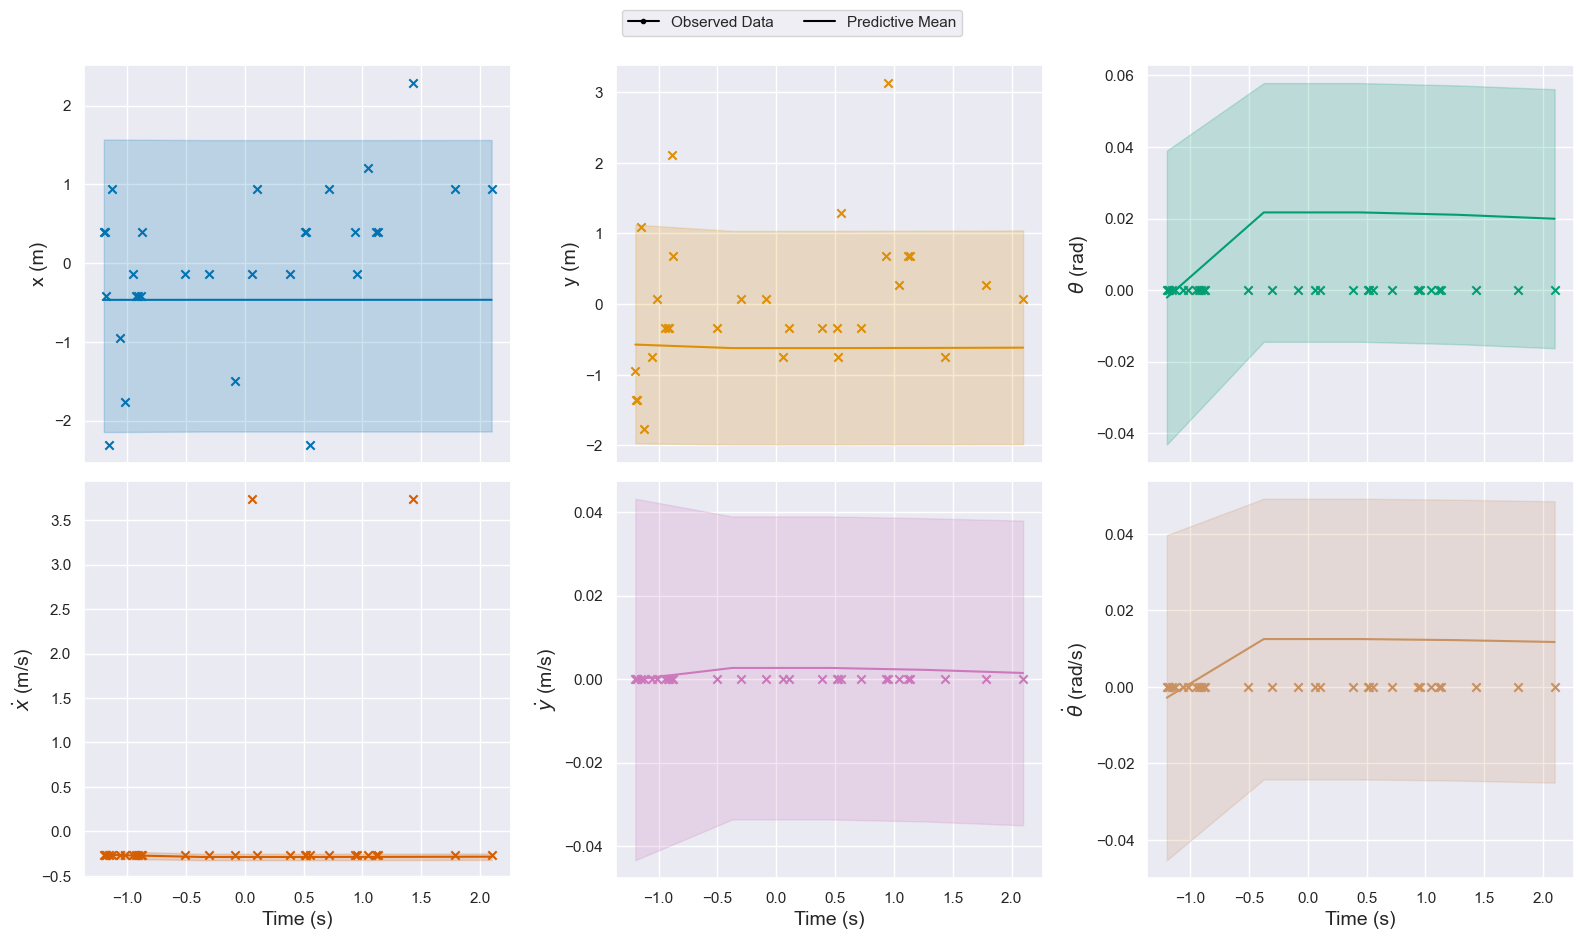

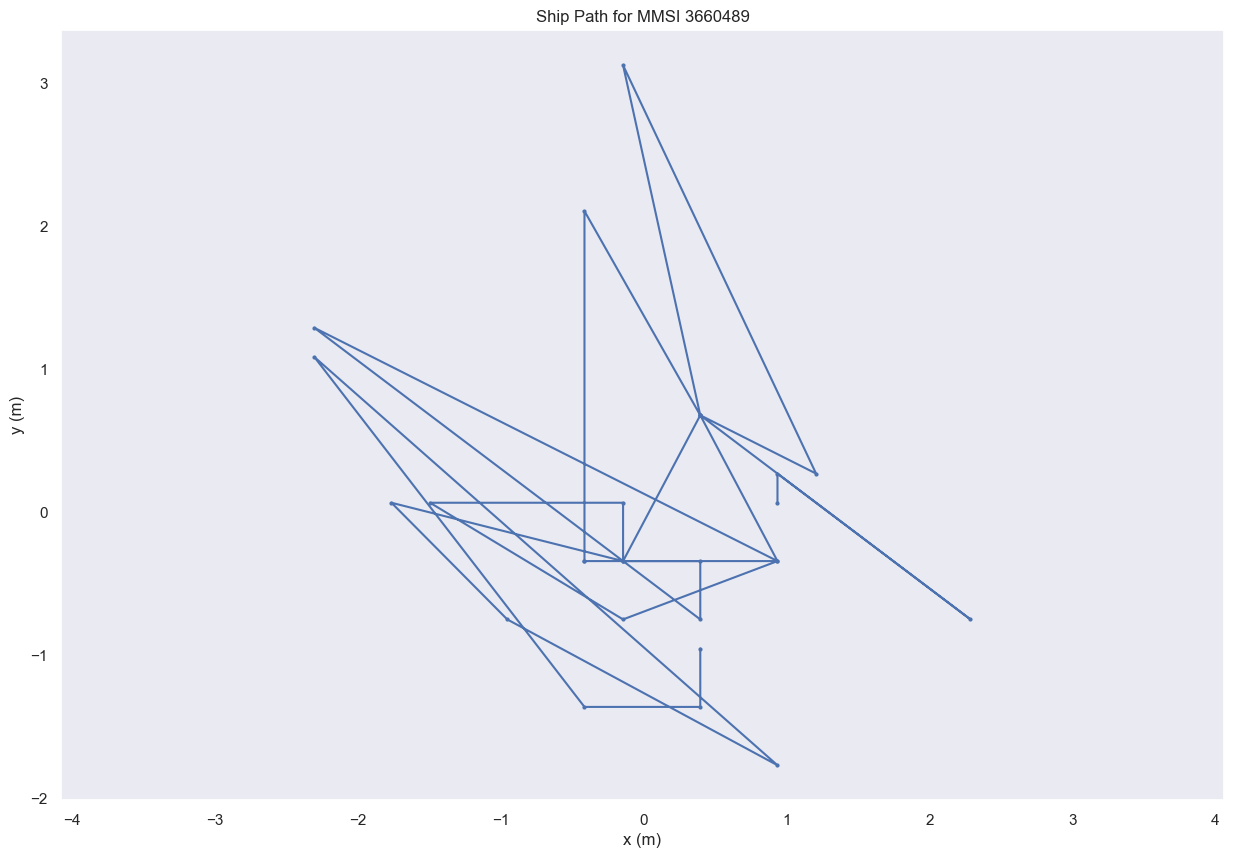

In [123]:
model.eval()
likelihood.eval()

for mmsi in models:
    model = models[mmsi]
    likelihood = likelihoods[mmsi]
    # Get the corresponding data for this MMSI
    # If you want to use the same train/test split as before:
    times, state_trajectory = None, None
    for entry in gp_regression_dataset:
        if entry[0] == mmsi:
            _, times, state_trajectory = entry
            break
    if times is None:
        continue  # skip if MMSI not found

    train_X = times.clone().detach().unsqueeze(1).cpu()
    train_Y = state_trajectory.clone().detach().cpu()

    test_X = torch.linspace(times.min(), times.max(), 5).unsqueeze(1).to(device)
    
    test_Y = eval_model(model, likelihood, test_X)

    plot_gp(train_X, train_Y, test_X, test_Y)
    plot_single_ship_path(mmsi, times, state_trajectory)


In [107]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from plotting_utils import *


def plot_for_mmsi(selected_mmsi):
    clear_output(wait=True)
    model = models[selected_mmsi]
    likelihood = likelihoods[selected_mmsi]
    # Get the corresponding data for this MMSI
    times, state_trajectory = None, None
    for entry in gp_regression_dataset:
        if entry[0] == selected_mmsi:
            _, times, state_trajectory = entry
            break
    if times is None:
        print("No data for MMSI:", selected_mmsi)
        return

    train_X = times.clone().detach().unsqueeze(1).cpu()
    train_Y = state_trajectory.clone().detach().cpu()
    test_X = torch.linspace(times.min(), times.max(), 500).unsqueeze(1).to(device)
    test_Y = eval_model(model, likelihood, test_X)

    plot_gp(train_X, train_Y, test_X, test_Y)
    plot_single_ship_path(selected_mmsi, times, state_trajectory)

    
mmsi_dropdown = widgets.Dropdown(
    options=list(models.keys()),
    description='MMSI:',
    disabled=False,
)

widgets.interact(plot_for_mmsi, selected_mmsi=mmsi_dropdown)
    
    
    

interactive(children=(Dropdown(description='MMSI:', options=(3660489,), value=3660489), Output()), _dom_classe…

<function __main__.plot_for_mmsi(selected_mmsi)>

In [ ]:
print(pd.unique(gp_regression_dataset.df['MMSI'].values))
gp_regression_dataset.get_vessel_group_by_mmsi(3660489)

[367669550 367118980 636018568 ... 367619000 309108000 368926390]


'Other'

## Create the kernel param to ship mmsi dataset


In [ ]:
kernel_classification_dataset = GPKernelShipClassificationDataset(gp_regression_dataset, models, device, scalers_by_mmsi=gp_regression_dataset.scalers_by_mmsi)
unique_group_ids = kernel_classification_dataset.get_unique_group_ids()

train_classification_dataset, test_classification_dataset = torch.utils.data.random_split(kernel_classification_dataset, [0.8, 0.2])
train_loader = torch.utils.data.DataLoader(train_classification_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_classification_dataset, batch_size=32, shuffle=False)

In [ ]:
# torch.save(kernel_classification_dataset, 'kernel_classification_dataset.pt')
save_dict = {
    "kernel_classification_dataset": kernel_classification_dataset,  # Only if this is safe to pickle!
    "models_state_dict": {k: v.state_dict() for k, v in models.items()},
    "likelihoods_state_dict": {k: v.state_dict() for k, v in likelihoods.items()},
    "losses": losses,
}
torch.save(save_dict, "kernel_classification_bundle.pt")

## Train the classification model

In [ ]:
from gp_kernel_ship_classification_network import GPKernelShipClassificationNetwork
model = GPKernelShipClassificationNetwork(input_dim=2, num_classes=max(unique_group_ids) + 1).to(device)  # +1 for background class

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

trainer = GPKernelShipClassificationTrainer(model, train_loader, test_loader, criterion, optimizer, device)
trainer.train(num_epochs=500)

GP Kernel Ship Classification Training: 100%|██████████| 500/500 [01:20<00:00,  6.25it/s]

Epoch 500/500 | Train Loss: 1.6226 | Train Acc: 0.3663 | Test Loss: 1.6634 | Test Acc: 0.3754


## Predictions

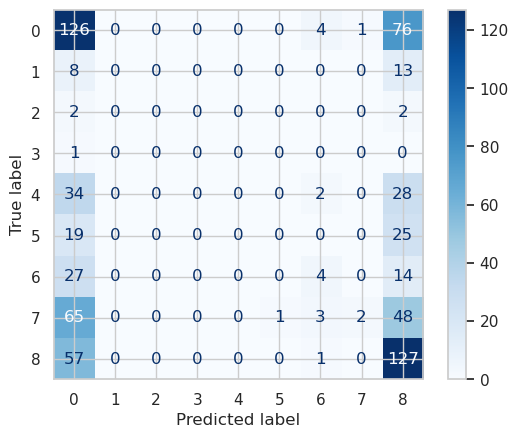

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        mmsi, X, y = batch  # adjust if your batch is structured differently
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

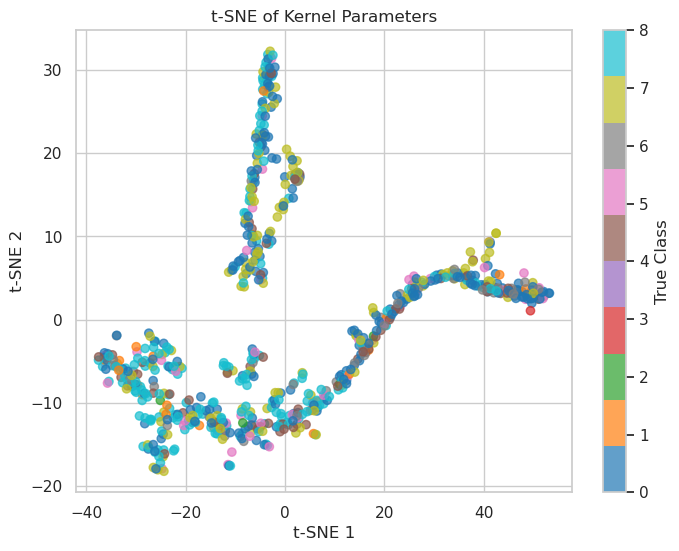

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

# Collect all features (X) and labels (y) from the test set
all_features = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        mmsi, X, y = batch
        all_features.append(X.cpu())
        all_labels.extend(y.cpu().numpy())

# Stack all features into a single array
all_features = torch.cat(all_features, dim=0).numpy()
all_labels = np.array(all_labels)

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(all_features)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='True Class')
plt.title('t-SNE of Kernel Parameters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()